# Malware Family Classification: Summary and Model Comparison

> Author: Tien Ly  
> CS 271: Topics in Machine Learning - Spring 2025 at San Jose State University

This notebook compares the performance of various embedding and classifier combinations used for malware family classification, including traditional machine learning models and CNN-based approaches. Based on accuracy, the top 2 models are selected for further hyperparameter tuning to improve performance. This is the final notebook in the `malware-ml` series.


## Section 1: Data Loading

In [1]:
# %pip install numpy pandas matplotlib seaborn scikit-learn xgboost gensim transformers torch ipykernel ipywidgets

In [4]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [5]:
def set_seed(seed_value=42):
    """ Set random seeds for reproducibility """

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [6]:
base_path = 'data_family/AllFiles_CleanLogAPI'
malware_families = os.listdir(base_path)
malware_families.sort()

print(f'Malware families: {malware_families}')

Malware families: ['adload', 'bancos', 'onlinegames', 'vbinject', 'vundo', 'winwebsec', 'zwangi']


In [7]:
# Read the dataset prepared in the previous notebook (malware1.ipynb)
malware = pd.read_pickle('malware_embed.pkl')
display(malware)

,filename,family,api_calls,family_encoded,w2v_embedding,bert_embedding
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.24319828590456427, 0.4095204386687955, 0.07...","[-0.7991742, 0.3438263, -0.10384858, -0.052014..."
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.3192994119176133, 0.3126627394195759, 0.107...","[-1.1525007, 0.30858508, -0.34731704, -0.10876..."
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.35232870802807975, 0.3023313647398437, 0.09...","[-0.6354753, 0.208447, -0.12664948, 0.04532755..."
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.21419722015776163, 0.4685576191910033, 0.07...","[-1.0789568, 0.3932857, -0.15799811, -0.234006..."
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.2497971701846158, 0.44478531367287544, 0.06...","[-0.86646986, 0.37369943, -0.11611564, -0.0787..."
...,...,...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.0765549134137521, 0.5077977184251578, 0.116...","[-0.92455983, 0.44403458, -0.12784415, -0.0387..."
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.07529302820632303, 0.4951471873300357, 0.15...","[-0.91322607, 0.42482898, -0.11122756, -0.0340..."
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.036983148374461705, 0.49100753841589073, 0....","[-0.9373291, 0.3942882, -0.099821806, -0.02300..."
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.1370665498430262, 0.4759025306919137, 0.099...","[-0.97449404, 0.5244397, -0.19178858, -0.28637..."


## Section 2: Hyperparameter Tuning

### 2.1 Word2Vec-RF

In [31]:
# Prepare Word2Vec features and target
X_word2vec = np.array(malware['w2v_embedding'].tolist())
y = malware['family_encoded']

# Split data into training and testing sets
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    X_word2vec, y, test_size=0.2, stratify=y, shuffle=True, random_state=42
)

# Initialize Random Forest classifier
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)

In [32]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500], # number of trees
    'max_depth': [10, 20, 30], # tree depth
    'min_samples_split': [2, 5, 10] # minimum number of samples to split
}

# Perform grid search
rf_word2vec_grid_search = GridSearchCV(
    estimator=rf_word2vec,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)
rf_word2vec_grid_search.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=1)

In [33]:
# Best parameters and accuracy
print("Word2Vec-RF grid search results:")
print("Best parameters: ", rf_word2vec_grid_search.best_params_)
print("Best accuracy: ", rf_word2vec_grid_search.best_score_)

# Evaluate on test set
best_rf_word2vec = rf_word2vec_grid_search.best_estimator_
y_pred_rf_word2vec = best_rf_word2vec.predict(X_test_word2vec)
print("\nTest set performance:")
print(classification_report(y_test_word2vec, y_pred_rf_word2vec, target_names=malware_families))

Word2Vec-RF grid search results:
Best parameters:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.8804608893216488

Test set performance:
              precision    recall  f1-score   support

      adload       1.00      1.00      1.00        14
      bancos       0.91      0.71      0.80        14
 onlinegames       0.73      0.79      0.76        14
    vbinject       0.75      0.86      0.80        14
       vundo       1.00      0.93      0.97        15
   winwebsec       0.79      0.79      0.79        14
      zwangi       0.93      1.00      0.97        14

    accuracy                           0.87        99
   macro avg       0.87      0.87      0.87        99
weighted avg       0.87      0.87      0.87        99



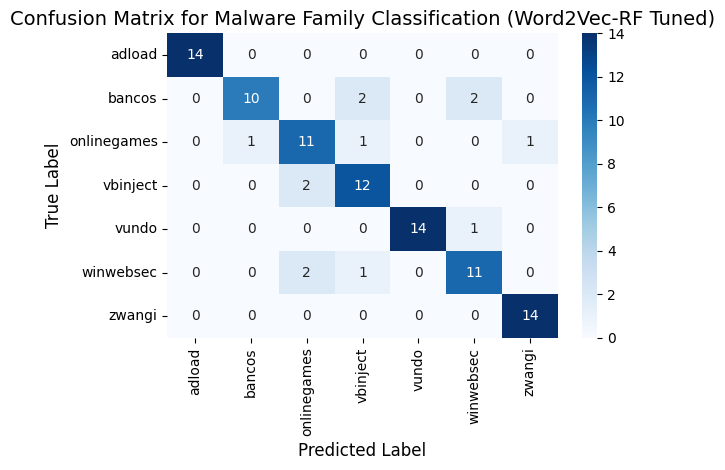

In [35]:
# Generate the confusion matrix
cm_rf_word2vec = confusion_matrix(y_test_word2vec, y_pred_rf_word2vec)
cm_rf_word2vec_df = pd.DataFrame(cm_rf_word2vec, index=malware_families, columns=malware_families)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_rf_word2vec_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (Word2Vec-RF Tuned)', fontsize=14)

plt.tight_layout()

### 2.2 BERT-CNN

#### 2.2.1 CNN Model

In [8]:
# Load pre-trained model tokenizer (vocabulary)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# Split the data into training, validation, and test sets (80% training, 10% validation, 10% test)
X = malware['api_calls'].tolist()
y_tensor = torch.tensor(malware['family_encoded'])

X_train, X_temp, y_train_bert_tensor, y_temp_bert_tensor = \
    train_test_split(X, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

X_val, X_test, y_val_bert_tensor, y_test_bert_tensor = \
    train_test_split(X_temp, y_temp_bert_tensor, test_size=0.5, random_state=42, stratify=y_temp_bert_tensor)

In [10]:
# Tokenize the training, validation, and test sets
X_train_bert_tensor = bert_tokenizer(X_train, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False) 
X_val_bert_tensor = bert_tokenizer(X_val, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False)
X_test_bert_tensor = bert_tokenizer(X_test, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False) 

In [11]:
# Create TensorDataset objects
bert_train_dataset = TensorDataset(X_train_bert_tensor['input_ids'], X_train_bert_tensor['attention_mask'], y_train_bert_tensor)
bert_val_dataset = TensorDataset(X_val_bert_tensor['input_ids'], X_val_bert_tensor['attention_mask'], y_val_bert_tensor)
bert_test_dataset = TensorDataset(X_test_bert_tensor['input_ids'], X_test_bert_tensor['attention_mask'], y_test_bert_tensor)

In [12]:
BATCH_SIZE = 50

# Create DataLoader objects for batch processing
bert_train_dataloader = DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bert_val_dataloader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
bert_test_dataloader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Set computation device
if torch.cuda.is_available():       
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA RTX 4000 Ada Generation


In [14]:
class BERT_CNN(nn.Module):
    def __init__(self, num_classes, bert_model_name='bert-base-uncased', num_filters=100, filter_sizes=[3, 4, 5], dropout_rate=0.5, freeze_bert=True):
        """
        Initializes the BERT-CNN model

        Args:
            num_classes (int): Number of output classes
            bert_model_name (str): Pre-trained BERT model name
            num_filters (int): Number of filters for each convolutional layer
            filter_sizes (list): List of filter sizes for convolutional layers
            dropout_rate (float): Dropout rate for regularization
            freeze_bert (bool): Whether to freeze BERT parameters during training
        """
        super().__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Freeze BERT parameters if specified
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # BERT embedding dimension is 768 for bert-base-uncased
        self.embedding_dim = 768
        
        # Convolutional layers with different filter sizes
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embedding_dim,
                    out_channels=num_filters, 
                    kernel_size=fs)
            for fs in filter_sizes
        ])
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the network
        
        Args:
            input_ids (torch.Tensor): Input token IDs
            attention_mask (torch.Tensor): Attention mask for padding tokens
        """
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state # [batch_size, seq_len, hidden_size]
        
        # Apply CNN on BERT embeddings
        # Transpose for conv1d [batch_size, embedding_dim, seq_len]
        x = sequence_output.permute(0, 2, 1)
        
        # Apply convolutions
        conv_outputs = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]
        
        # Apply max pooling
        pooled_outputs = [F.max_pool1d(output, output.shape[2]) for output in conv_outputs]
        
        # Concatenate the pooled outputs
        fc_input = torch.cat([output.squeeze(dim=2) for output in pooled_outputs], dim=1)
        
        # Apply dropout and classification layer
        logits = self.fc(self.dropout(fc_input))
        
        return logits

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  """
  Trains model for one epoch

  Args:
      model (nn.Module): The model to train
      dataloader (DataLoader): DataLoader for training data
      criterion (nn.Module): Loss function
      optimizer (torch.optim.Optimizer): Optimizer
      device (torch.device): Device to run the model on
  """
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for input_ids, attention_mask, labels in dataloader:
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_ids, attention_mask)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Compute average loss and accuracy
  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy

In [16]:
def evaluate(model, dataloader, criterion, device):
  """
  Evaluates model performance

    Args:
        model (nn.Module): The model to evaluate
        dataloader (DataLoader): DataLoader for evaluation data
        criterion (nn.Module): Loss function
        device (torch.device): Device to run the model on
  """
  model.eval()

  running_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for input_ids, attention_mask, labels in dataloader:
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

      outputs = model(input_ids, attention_mask)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Store predictions and labels
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy, all_preds, all_labels

#### 2.2.2 Tuning

In [ ]:
# Define the hyperparameter search space
cnn_param_grid = {
    'num_filters': [50, 100, 150],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create a grid of all possible combinations
cnn_grid = list(ParameterGrid(cnn_param_grid))
print(f'Total number of combinations: {len(cnn_grid)}')

In [ ]:
# Run hyperparameter tuning
num_epochs = 50
early_stopping_patience = 20
cnn_bert_grid_search_results = []

for i, params in enumerate(cnn_grid):
    print(f"\nTesting combination {i+1}/{len(cnn_grid)}")
    print(f"Parameters: {params}")
    
    # Initialize model with current hyperparameters
    model = BERT_CNN(
        num_classes=len(malware_families),
        bert_model_name='bert-base-uncased',
        num_filters=params['num_filters'],
        filter_sizes=[3, 4, 5],
        dropout_rate=params['dropout_rate'],
        freeze_bert=True
    ).to(device)
    
    # Initialize optimizer with current learning rate
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0
    early_stopping_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_accuracy = train_epoch(model, bert_train_dataloader, criterion, optimizer, device)
        
        # Evaluate on validation set
        val_loss, val_accuracy, _, _ = evaluate(model, bert_val_dataloader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train loss: {train_loss:.4f}. Train accuracy: {train_accuracy:.2f}%')
        print(f'  Validation loss: {val_loss:.4f}. Validation accuracy: {val_accuracy:.2f}%')
        
        # Check for improvement
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Save results
    cnn_bert_grid_search_results.append({
        'params': params,
        'best_val_accuracy': best_val_accuracy,
        'epochs_trained': epoch + 1
    })
    
    # Sort results by validation accuracy and print the best so far
    cnn_bert_grid_search_results.sort(key=lambda x: x['best_val_accuracy'], reverse=True)
    print("\nBest results so far:")
    for j, result in enumerate(cnn_bert_grid_search_results[:3]):
        print(f"{j+1}. Accuracy: {result['best_val_accuracy']:.2f}% - {result['params']}")

In [ ]:
# Sort and display final results
cnn_bert_grid_search_results.sort(key=lambda x: x['best_val_accuracy'], reverse=True)
print('BERT-CNN grid search results:')
print(f"Best hyperparameters: {cnn_bert_grid_search_results[0]['params']}")
print(f"Best validation accuracy: {cnn_bert_grid_search_results[0]['best_val_accuracy']:.2f}%")

# Save best hyperparameters
cnn_bert_best_params = cnn_bert_grid_search_results[0]['params']

BERT-CNN grid search results:
Best hyperparameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'num_filters': 50}
Best validation accuracy: 95.92%


#### 2.3 Tuned CNN Model

In [21]:
# Train final model with best hyperparameters
best_cnn_bert = BERT_CNN(
    num_classes=len(malware_families),
    bert_model_name='bert-base-uncased',
    num_filters=cnn_bert_best_params['num_filters'],
    filter_sizes=[3, 4, 5],
    dropout_rate=cnn_bert_best_params['dropout_rate'],
    freeze_bert=True
).to(device)

bert_cnn_criterion = nn.CrossEntropyLoss()
bert_cnn_optimizer = optim.Adam(best_cnn_bert.parameters(), lr=cnn_bert_best_params['learning_rate'])
bert_cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(bert_cnn_optimizer, mode='min', factor=0.5, patience=10)

In [22]:
num_epochs = 50
best_accuracy = 0.0
early_stopping_counter = 0
early_stopping_patience = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
  # Train one epoch
  train_loss, train_accuracy = train_epoch(best_cnn_bert, bert_train_dataloader, bert_cnn_criterion, bert_cnn_optimizer, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Evaluate on validation set
  val_loss, val_accuracy, _, _ = evaluate(best_cnn_bert, bert_val_dataloader, bert_cnn_criterion, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Update learning rate
  bert_cnn_scheduler.step(val_loss)

  # Print metrics
  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'  Train loss: {train_loss:.4f}. Train accuracy: {train_accuracy:.2f}%')
  print(f'  Validation loss: {val_loss:.4f}. Validation accuracy: {val_accuracy:.2f}%')

  # Save best model
  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    torch.save(best_cnn_bert.state_dict(), 'best_bert_cnn_model_tuned.pt')
    print(f'  Saved new best model with accuracy: {best_accuracy:.2f}%')
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  # Early stopping
  if early_stopping_counter >= early_stopping_patience:
    print(f'Early stopping triggered after {epoch+1} epochs')
    break

print(f'Training completed after {epoch+1} epochs. Best validation accuracy: {best_accuracy:.2f}%')
# Load best model for evaluation
best_cnn_bert.load_state_dict(torch.load('best_bert_cnn_model_tuned.pt'))

Starting training...


Epoch 1/50
  Train loss: 2.0843. Train accuracy: 25.95%
  Validation loss: 1.1568. Validation accuracy: 59.18%
  Saved new best model with accuracy: 59.18%
Epoch 2/50
  Train loss: 1.2735. Train accuracy: 51.65%
  Validation loss: 0.8396. Validation accuracy: 75.51%
  Saved new best model with accuracy: 75.51%
Epoch 3/50
  Train loss: 0.9471. Train accuracy: 70.74%
  Validation loss: 0.6259. Validation accuracy: 79.59%
  Saved new best model with accuracy: 79.59%
Epoch 4/50
  Train loss: 0.7754. Train accuracy: 78.12%
  Validation loss: 0.5054. Validation accuracy: 85.71%
  Saved new best model with accuracy: 85.71%
Epoch 5/50
  Train loss: 0.7211. Train accuracy: 75.32%
  Validation loss: 0.5196. Validation accuracy: 87.76%
  Saved new best model with accuracy: 87.76%
Epoch 6/50
  Train loss: 0.7320. Train accuracy: 77.10%
  Validation loss: 0.4882. Validation accuracy: 85.71%
Epoch 7/50
  Train loss: 0.5955. Train accuracy: 80.15%
  Validation loss: 0.5048. Validation accuracy: 87.76

<All keys matched successfully>

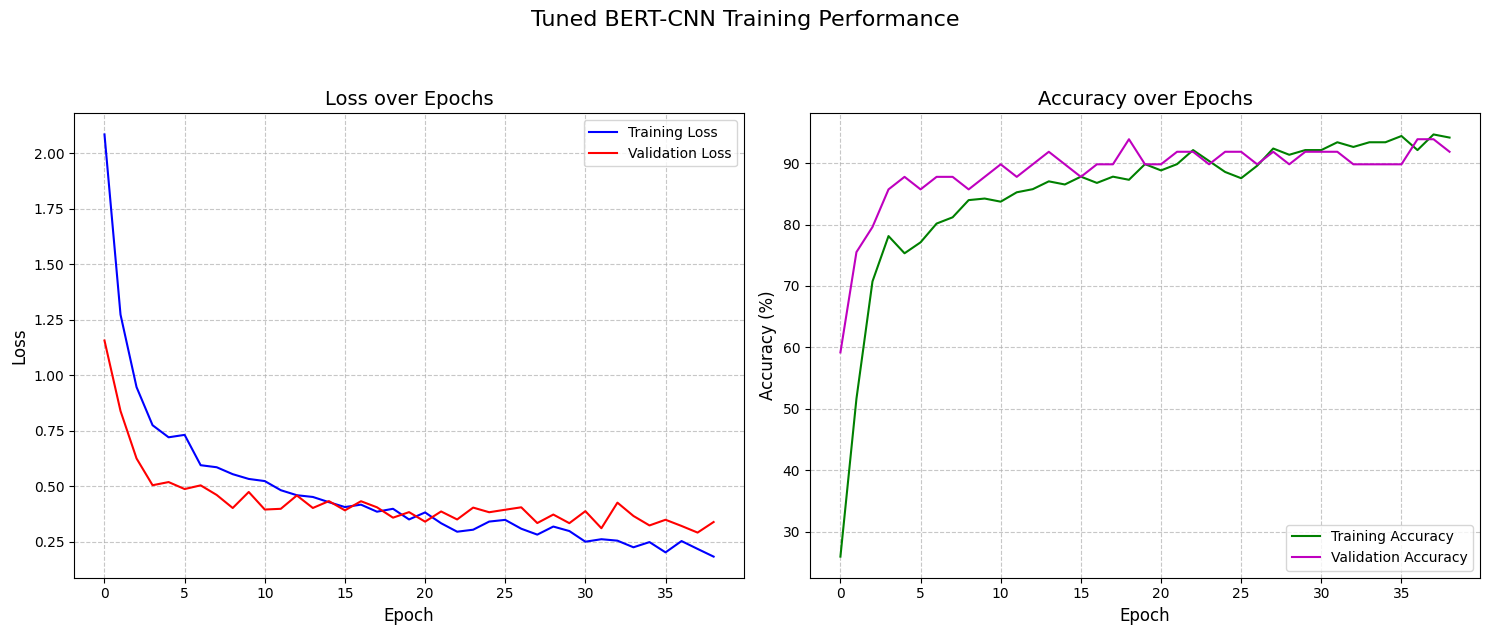

In [41]:
plt.figure(figsize=(15, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'g-', label='Training Accuracy')
plt.plot(val_accuracies, 'm-', label='Validation Accuracy')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.suptitle('Tuned BERT-CNN Training Performance', fontsize=16, y=1.05)
plt.tight_layout()

In [24]:
# Evaluation
test_loss, test_accuracy, y_pred_bert_cnn, y_true_bert_cnn = evaluate(best_cnn_bert, bert_test_dataloader, bert_cnn_criterion, device)

print('Tuned BERT-CNN Classifier:')
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")
print(classification_report(y_true_bert_cnn, y_pred_bert_cnn, target_names=malware_families))

Tuned BERT-CNN Classifier:
Test loss: 0.5589
Test accuracy: 86.00%
              precision    recall  f1-score   support

      adload       0.88      1.00      0.93         7
      bancos       0.60      0.86      0.71         7
 onlinegames       0.86      0.86      0.86         7
    vbinject       0.86      0.86      0.86         7
       vundo       1.00      0.88      0.93         8
   winwebsec       1.00      0.57      0.73         7
      zwangi       1.00      1.00      1.00         7

    accuracy                           0.86        50
   macro avg       0.88      0.86      0.86        50
weighted avg       0.89      0.86      0.86        50



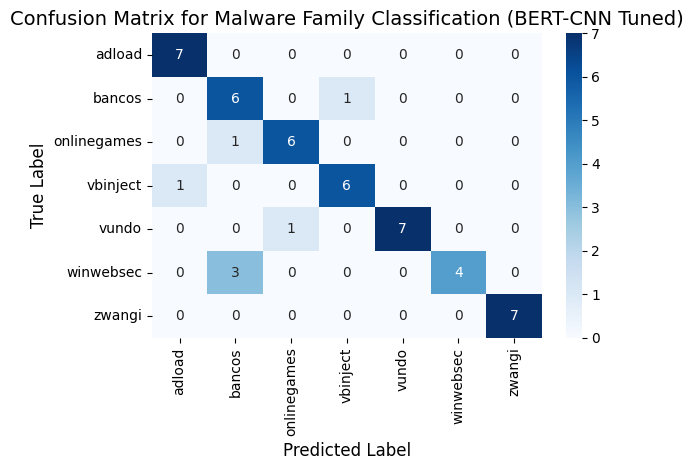

In [42]:
# Generate confusion matrix
cm_bert_cnn = confusion_matrix(y_true_bert_cnn, y_pred_bert_cnn)
cm_bert_cnn_df = pd.DataFrame(cm_bert_cnn, index=malware_families, columns=malware_families)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_bert_cnn_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (BERT-CNN Tuned)', fontsize=14)
plt.tight_layout()

## Section 4: Summary

In [56]:
# Update accuracies DataFrame
accuracies_df = pd.read_pickle('accuracies.pkl')

new_results = pd.DataFrame([
    {'embedding': 'Word2Vec', 'classifier': 'Random Forest (Tuned)', 'accuracy': round(accuracy_score(y_test_word2vec, y_pred_rf_word2vec), 2)},
    {'embedding': 'BERT', 'classifier': 'CNN (Tuned)', 'accuracy': round(accuracy_score(y_true_bert_cnn, y_pred_bert_cnn), 2)}
])

accuracies_df = pd.concat([accuracies_df, new_results], ignore_index=True)
accuracies_df.to_pickle('accuracies.pkl')

In [61]:
accuracies_df = accuracies_df.sort_values(['embedding', 'classifier'])
accuracies_df

,embedding,classifier,accuracy
5,BERT,CNN,0.90
7,BERT,CNN (Tuned),0.86
1,BERT,Random Forest,0.86
3,BERT,XGBoost,0.86
4,Word2Vec,CNN,0.86
0,Word2Vec,Random Forest,0.87
6,Word2Vec,Random Forest (Tuned),0.87
2,Word2Vec,XGBoost,0.86


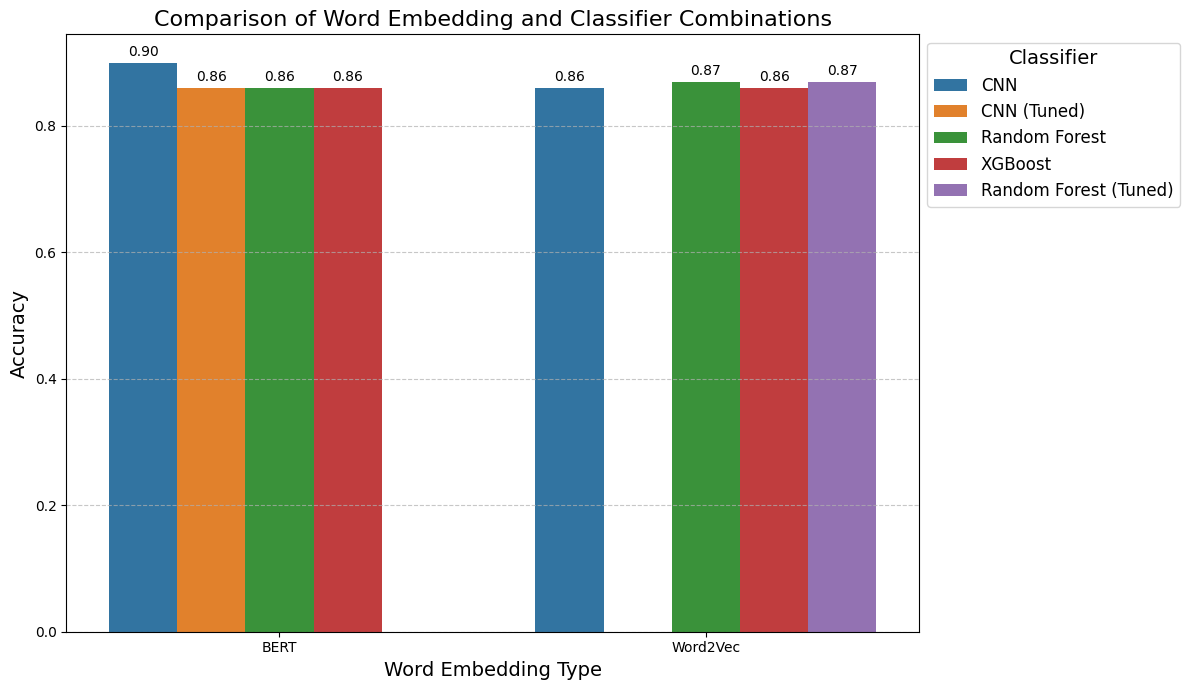

In [93]:
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=accuracies_df, 
    x='embedding', 
    y='accuracy', 
    hue='classifier'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Comparison of Word Embedding and Classifier Combinations', fontsize=16)
plt.xlabel('Word Embedding Type', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.legend(title='Classifier', title_fontsize=14, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()